<a href="https://colab.research.google.com/github/mimorep/TrabajoDistribuidos/blob/master/ClasificadorDeImagenes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Clasificador de principales marcas alemanas de coches

Este es el notebook en el que se va a crear un clasificador de imágenes para las 3 principales marcas Alemanas de coches: Audi, Bmw y Mercedes

Por complicarlo un poco más he añadido otras 2 marcas (que son propiedad de Audi y de Bmw): Rolls y Bently


## Cargando las librerías

Vamos a cargar las librerías que vamos a necesitar para el desarrollo de este notebook

In [0]:
from fastai.vision import *
import os
from google.colab import files

Lo primero que vamos a hacer antes de continuar va a ser activar la GPU, para este entorno de trabajo para ello: Editar -> configuración del cuaderno -> GPU


Para crear el dataset, vamos a utilizar los comandos proporcionados en las instrucciones del entregable para descargar las imagenes, todas ellas van a ser guardadas en una carpeta de drive que más tarde usaremos como directorio (he tomado esta decisión ya que por la experiencia de la práctica 8 ampliación 2, creo que es lo mejor).

Yo lo he integrado directamente, pero por si quieres probarlo te dejo un link a la carpeta pública con el dataset: https://drive.google.com/open?id=18sqlF5r1RWkxnZ1T-YxAa8VNw2FhIVXb

Ahora vamos a proceder a organizarlo todo en carpetas

In [3]:
!ls 'drive/My Drive/DataSetCoches'

Audi.csv  Bentley.csv  Bmw.csv	Mercedes.csv  Rolls-Royce.csv


Movemos los csv a la nueva carpeta donde generamos las imagenes

In [21]:
#Audi
#Como en el anterior descargamos como max 200 imagenes
download_images(Path('/content/DataSetCoches/Audi.csv'), Path('/content/DataSetCoches/Audi'), max_pics=200)

In [22]:
#BMW
#Como en el anterior descargamos como max 200 imagenes
download_images(Path('/content/DataSetCoches/Bmw.csv'), Path('/content/DataSetCoches/Bmw'), max_pics=200)

In [23]:
#Mercedes
#Como en el anterior descargamos como max 200 imagenes
download_images(Path('/content/DataSetCoches/Mercedes.csv'), Path('/content/DataSetCoches/Mercedes'), max_pics=200)

In [24]:
#Rolls
#Como en el anterior descargamos como max 200 imagenes
download_images(Path('/content/DataSetCoches/Rolls-Royce.csv'), Path('/content/DataSetCoches/Rolls-Royce'), max_pics=200)

In [25]:
#Bently
#Como en el anterior descargamos como max 200 imagenes
download_images(Path('/content/DataSetCoches/Bentley.csv'), Path('/content/DataSetCoches/Bentley'), max_pics=200)

Ahora vamos a comprobrar que las imágnes tengan el formato adecuado

In [31]:
path = Path('DataSetCoches')
for c in ['Audi', 'Bentley', 'Bmw', 'Mercedes', 'Rolls-Royce']:
  print(c)
  verify_images(path/c, delete=True, max_size=500)

Audi


Bentley


Bmw


Mercedes


Rolls-Royce


Parece que todas las fotos cumplen las propiedades

##Mostrando algunas imagenes

Como en el anterior notebook vamos a mostrar alguna de las imagenes y partir nuestro dataset en el conjunto de entrenamiento y de validación (20%)

In [0]:
np.random.seed(77) #Para que en distintas ejecuciones nos salgan los mismo resultados
#El size lo ponemos a 224 por que es el que requiere el algoritmo
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2, ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

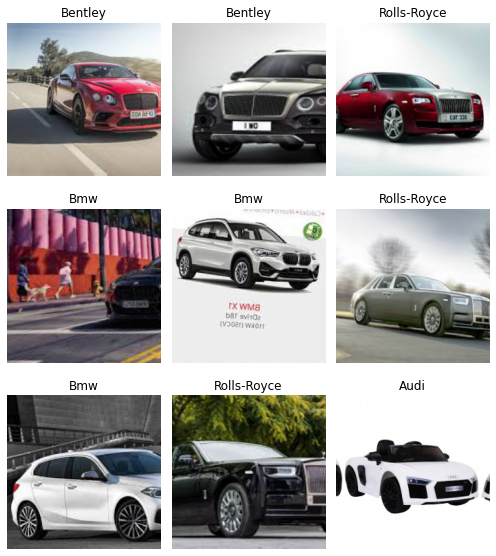

In [33]:
#Mostramos algunos datos del batch
data.show_batch(rows=3,figsize=(7,8))

##Creando el modelo

Ahora que ya hemos visto las estructuras de los datos, vamos a pasar a ver como se haría la creación del modelo, utilizando ResNet 34

In [34]:
learn = create_cnn(data,models.resnet34,metrics=[error_rate,accuracy])

/usr/local/lib/python3.6/dist-packages/fastai/vision/learner.py:106: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")
Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


##Entrenamiento

Ahora vamos a pasar a entrenar la red siguiendo la idea de fine-tuning

In [35]:
learn.fit_one_cycle(4) #Solo para las ultimas capas

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,2.786804,1.865028,0.675000,0.325000,00:04
1,2.308825,1.913114,0.537500,0.462500,00:04
2,1.871707,1.757751,0.500000,0.500000,00:04
3,1.629991,1.615983,0.450000,0.550000,00:04


Como podemos ver los resultados no es que sean muy buenos, vamos a ver si podemos mejorarlos, de momento vamos a guardar el estado de la red

In [0]:
learn.save('stage-1')

In [0]:
#Descongelamos la red
learn.unfreeze()

In [40]:
#Reentrenamos las capas de la red
learn.fit_one_cycle(4,max_lr=slice(3e-5,3e-4))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.370023,1.413594,0.337500,0.662500,00:04
1,0.373672,1.360690,0.362500,0.637500,00:04
2,0.307520,1.302022,0.325000,0.675000,00:04
3,0.282000,1.275998,0.325000,0.675000,00:04


Como podemos ver el rendimiento a mejorado bastante (pero sigue siendo inferior al otro modelo)

In [0]:
learn.save('stage-2')

Vamos a sacar la matriz de confusión par ver cuales son las clases que se están confundiendo

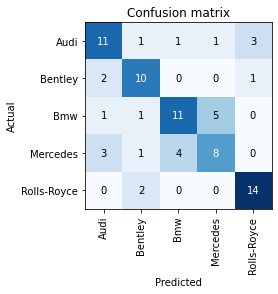

In [42]:
learn.load('stage-2')
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

Como podemos ver las clases están bastante correlaccinodas entre si, es algo normal ya que desde un principio esta idea éra copleja todo los coches son muy parecidos entre si (todos tienen 4 ruedas, el color es independitente de la marca.. etc)

Pero aun asi podemos ver que los resultados son "buenos", por ejemplo en el caso de audi solo es confindido un poco con Rolls, siendo el caso más notable el de Mercedes con Bmw

## Limpiando el dataset (Ampliación)

Antes de entrenar por más tiempo la red, vamos a emplear una técnica de limpiado de imagenes para descartar alguna de las imagenes que menos relevancia tienen en nuestras preducciones (así conseguiremos mejores resultados).

In [0]:
#importamos la libreria
from fastai.widgets import *

In [45]:
#Buscamos las imagene con mayor perdida
ds, idxs = DatasetFormatter().from_toplosses(learn, ds_type= DatasetType.Valid)

In [46]:
#Mostramos las 10 que mayor perdida tienen
ds.to_df().iloc[idxs[:10]]

,x,y
143,Bentley/00000000.jpg,Bentley
164,Bentley/00000035.jpg,Bentley
0,Bmw/00000042.jpg,Bmw
198,Audi/00000005.jpg,Audi
217,Audi/00000056.jpg,Audi
42,Bmw/00000006.jpg,Bmw
125,Mercedes/00000014.jpg,Mercedes
63,Mercedes/00000065.jpg,Mercedes
162,Bentley/00000003.jpg,Bentley
71,Mercedes/00000015.jpg,Mercedes


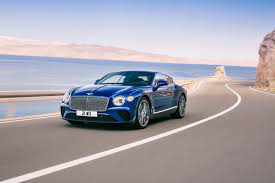

In [47]:
#Ahora las vamos a mostrar, para ver si podemos ver por que son las que mas perdida tienen
img = open_image(path/'Bentley'/'00000000.jpg')
img

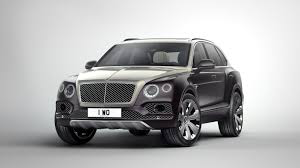

In [48]:
img = open_image(path/'Bentley'/'00000035.jpg')
img

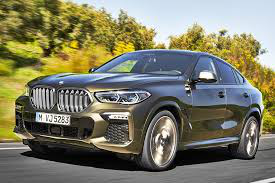

In [49]:
img = open_image(path/'Bmw'/'00000042.jpg')
img

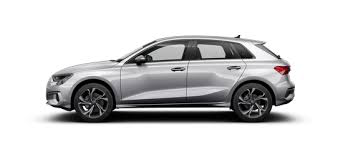

In [50]:
img = open_image(path/'Audi'/'00000005.jpg')
img

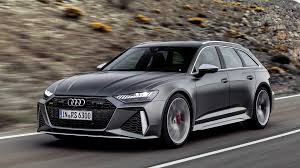

In [52]:
img = open_image(path/'Audi'/'00000056.jpg')
img

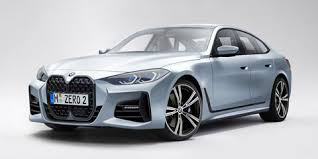

In [54]:
img = open_image(path/'Bmw'/'00000006.jpg')
img

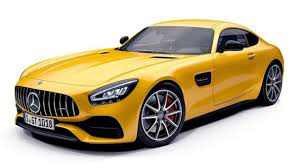

In [53]:
img = open_image(path/'Mercedes'/'00000014.jpg')
img

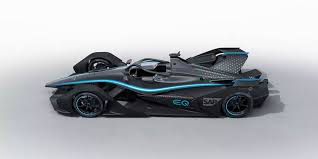

In [55]:
img = open_image(path/'Mercedes'/'00000065.jpg')
img

Como podemos ver muchas de las imágnes que causan pérdidas altas son:

- Las de SUVs (ya que hay muy pocos en el dataset, casi todos son berlinas o turismos)

- Las de vehículos que son prototipos de coches (como se ve en el caso de bmw y de mercedes)

- Las que son desde angulos raros (como es el caso de las que muestro de audi y la úlitima de mercedes)

Otras no son buenas y se desconoce el por que puede ser que sea porque el vehículo esta muy alegado o por que como en el caso del Rs6 al tener una aerodinámica tan afialada no sea bueno para compararlo con el resto que son contornos mas redondos(es una suposición).

Por ejemplo para corroborrar mi hipotesis podemos ver que no aparece ningun Rolls en esta sección. (Los Rolls son vehículos muy redondos sin apenas angulos afilados).

Lo que vamos a hacer ahora por tanto es eliminar esas imagenes del dataset para limpiarlo y que produca mejores predicciones

In [0]:
#Par ello vamos a eliminar estos 10 archivos que más perdidas probocan
#os.remove(path/'Bentley'/'00000000.jpg')
#os.remove(path/'Bentley'/'00000035.jpg')
#os.remove(path/'Bmw'/'00000042.jpg')
#os.remove(path/'Audi'/'00000005.jpg')
os.remove(path/'Audi'/'00000056.jpg') #Estan comentados los de arriba por que he fallado metiendo esta ruta, asi que en la segunda iteracion ya estaban borrados
os.remove(path/'Bmw'/'00000006.jpg')
os.remove(path/'Mercedes'/'00000014.jpg')
os.remove(path/'Mercedes'/'00000065.jpg')
os.remove(path/'Bentley'/'00000003.jpg')
os.remove(path/'Mercedes'/'00000015.jpg')

Ahora que tenemos el dataset más limpio, podemos entrenarlo para conseguir mejores predicciones

##Reentrenamiento con dataset limpio

In [0]:
#Creamos el nuevo dataset limpio
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2, ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

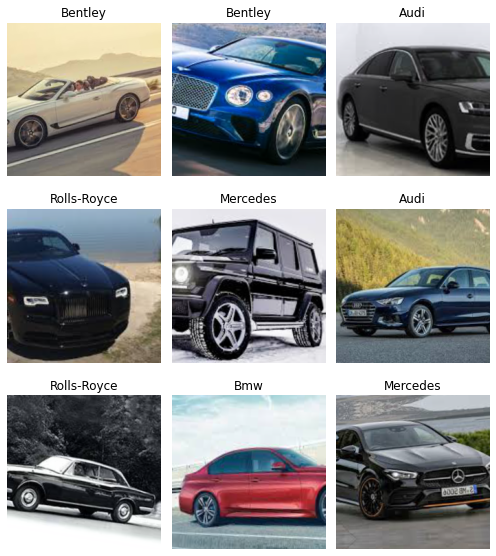

In [67]:
#Mostramos algunas de sus imagenes como antes
data.show_batch(rows=3,figsize=(7,8))

In [68]:
#Creamos de nuevo la red
learn = create_cnn(data,models.resnet34,metrics=[error_rate,accuracy])

/usr/local/lib/python3.6/dist-packages/fastai/vision/learner.py:106: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")


In [69]:
#Entrenamos las ultimas capas, pero le vamos a poner mas ciclos de entrenamiento
learn.fit_one_cycle(17)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,2.670990,1.968583,0.756410,0.243590,00:03
1,2.600683,1.489525,0.576923,0.423077,00:03
2,2.287375,1.327849,0.448718,0.551282,00:03
3,2.049553,1.262909,0.410256,0.589744,00:03
4,1.837303,1.119810,0.358974,0.641026,00:03
5,1.663340,1.015140,0.371795,0.628205,00:03
6,1.491110,1.092023,0.371795,0.628205,00:03
7,1.373895,1.188733,0.410256,0.589744,00:03
8,1.277932,1.220964,0.448718,0.551282,00:03
9,1.183117,1.281847,0.384615,0.615385,00:03


Podemos ver que respecto a la primera vez hemos conseguido mejores resultados, causados por la limpieza del dataset, asi como de por el aumento de iteraciones

In [0]:
#guardamos el modelo
learn.save('cleanStage-1')

In [0]:
#Descongelamos las capas
learn.unfreeze()

In [72]:
#Reentrenamos las capas, 17 iteraciones tambien
learn.fit_one_cycle(17,max_lr=slice(3e-5,3e-4))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.413546,1.274537,0.397436,0.602564,00:03
1,0.439098,1.277526,0.371795,0.628205,00:03
2,0.416566,1.268117,0.435897,0.564103,00:03
3,0.401044,1.254441,0.410256,0.589744,00:03
4,0.368799,1.258015,0.384615,0.615385,00:03
5,0.333789,1.156869,0.397436,0.602564,00:03
6,0.303313,1.058926,0.371795,0.628205,00:03
7,0.277850,1.073706,0.384615,0.615385,00:03
8,0.255842,1.154404,0.397436,0.602564,00:03
9,0.236089,1.199426,0.358974,0.641026,00:03


Los resultados parece que mejoran, pero siguen sin ser muy buenos asi que vamos a congelar la red y repetri el proceso pero con mas iteracines hasta por lo menos llegar a 70% (Considero dificil que pueda llegar a subir de 70 ya que el problema que se le plantea como y a hemos comentado es dificil)

In [0]:
#Congelamos la red
learn.freeze()

In [74]:
#Entrenamos los pesos de las ultimas capas
learn.fit_one_cycle(30)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.063928,1.110135,0.320513,0.679487,00:03
1,0.065322,1.128057,0.307692,0.692308,00:03
2,0.075194,1.126892,0.320513,0.679487,00:03
3,0.069971,1.122473,0.333333,0.666667,00:03
4,0.074935,1.110496,0.320513,0.679487,00:03
5,0.073420,1.075970,0.320513,0.679487,00:03
6,0.074383,1.111567,0.307692,0.692308,00:03
7,0.071984,1.319393,0.320513,0.679487,00:03
8,0.076231,1.564807,0.358974,0.641026,00:03
9,0.077249,1.573589,0.333333,0.666667,00:03


In [0]:
#Ahora descongelamos la red 
learn.unfreeze()

In [76]:
#Entrenamos las capas de nuevo, no estamos guardando estos ya que nose si los resultados van a ser buenos
learn.fit_one_cycle(30,max_lr=slice(3e-5,3e-4))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.053215,1.511106,0.307692,0.692308,00:03
1,0.041863,1.525332,0.320513,0.679487,00:03
2,0.053302,1.512200,0.333333,0.666667,00:03
3,0.043507,1.420451,0.320513,0.679487,00:03
4,0.048831,1.414492,0.294872,0.705128,00:03
5,0.047520,1.544009,0.333333,0.666667,00:03
6,0.046239,1.702408,0.346154,0.653846,00:03
7,0.048589,1.865004,0.346154,0.653846,00:03
8,0.050290,1.598240,0.358974,0.641026,00:03
9,0.049488,1.600662,0.307692,0.692308,00:03


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f8200577fd0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 961, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 941, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f8200577fd0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 961, in __del__
    self._shutdown_workers()
  File "/usr/local/l

Al final el resultado obtenido es de un 76% de acierto, considero que es un muy buen resultado, por el momento me conformare con el, pero si vemos que no predice bien los ejemplos lo entrenaremos mas para mejorarlos

In [0]:
#Lo guardamos
learn.save('cleanStage-2')

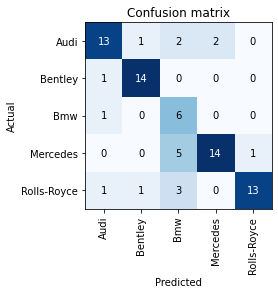

In [81]:
#Vamos a analizar los resultados
learn.load('cleanStage-2')
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

Gracias a esto podemos ver que los reslutados han mejorado enormemente, desapareciendo algunas relacciones enormes y manteniendose otras minimas.

##Creando el modelo para produccion (Adicional incluido)

En esta parte vamos a dejar listo el modelo para que pueda ser usado con cualquier imagen

In [0]:
learn.export()

In [79]:
#Comprobamos que se ha creado el fichero
!ls DataSetCoches

Audi	  Bentley      Bmw	export.pkl  Mercedes.csv  Rolls-Royce
Audi.csv  Bentley.csv  Bmw.csv	Mercedes    models	  Rolls-Royce.csv


In [0]:
#Ponemos la CPU para realizar la inferencia
defaults.device = torch.device('cpu')

Ahora vamos a probar nuestro modelo con varias imagenes, que podemos en contrar en la carpeta de drive ya mencionada

In [0]:
pathDrive = Path('drive/My Drive/DataSetCoches')

In [0]:
imgAudi = open_image(pathDrive/'audiA8.jpg')
imgBmw = open_image(pathDrive/'bmwM4.jpg')
imgMercedes = open_image(pathDrive/'MercedesCS.jpg')
imgRolls = open_image(pathDrive/'Phantom.jpg')
imgBently = open_image(pathDrive/'continentalGT.jpg')

In [0]:
learn = load_learner(path)

Realizamos las predicciones

In [86]:
pred_class, pred_idx, outputs = learn.predict(imgAudi)
pred_class

Category Audi

In [87]:
for imagen in [imgAudi, imgBmw, imgMercedes, imgRolls, imgBently]:
  pred_class, pred_idx, outputs = learn.predict(imagen)
  print(pred_class)

Audi
Bmw
Mercedes
Rolls-Royce
Bentley


Como vemos la prediccion es 100% correcta. Así que vamos a crear una aplicación para usarlo directamente

In [0]:
def detectaCocheLujo(image):
  #Obtenemos al algoritmo entrenado
  !wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1zUCpQPlF3eUwuRUvy1os06ehiyHjeH5h' -O /content/export.pkl
  #Cargamos el algoritmo
  learn = load_learner(Path('/content'))
  pred_class, pred_idx, outputs = learn.predict(image)
  print("La prediccion de esta imagen es " + str(pred_class))

def detectaCocheLujoPath(pathImagen):
  #Obtenemos al algoritmo entrenado
  !wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1zUCpQPlF3eUwuRUvy1os06ehiyHjeH5h' -O /content/export.pkl
  #Cargamos el algoritmo
  learn = load_learner(Path('/content'))
  image = open_image(pathImagen)
  pred_class, pred_idx, outputs = learn.predict(image)
  print("La prediccion de esta imagen es " + str(pred_class))

In [132]:
detectaCocheLujoPath(pathDrive/'bmwM4.jpg')

--2020-04-23 12:37:40--  https://docs.google.com/uc?export=download&id=1zUCpQPlF3eUwuRUvy1os06ehiyHjeH5h
Resolving docs.google.com (docs.google.com)... 74.125.195.138, 74.125.195.100, 74.125.195.113, ...
Connecting to docs.google.com (docs.google.com)|74.125.195.138|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0s-6c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/3vvf9u9nuv1d6ejqf6obnut4rofgbf5d/1587645450000/10411657993853324154/*/1zUCpQPlF3eUwuRUvy1os06ehiyHjeH5h?e=download [following]
--2020-04-23 12:37:44--  https://doc-0s-6c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/3vvf9u9nuv1d6ejqf6obnut4rofgbf5d/1587645450000/10411657993853324154/*/1zUCpQPlF3eUwuRUvy1os06ehiyHjeH5h?e=download
Resolving doc-0s-6c-docs.googleusercontent.com (doc-0s-6c-docs.googleusercontent.com)... 74.125.28.132, 2607:f8b0:400e:c04::84
Connecting to doc-0s-6c-docs.googleusercontent.com (doc-0s-6c-do